In [50]:
# pre-Processing

In [65]:
import sqlite3
import re
import emoji
import html
import pandas as pd
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# Load SpaCy model (BERT-based)
nlp = spacy.load("en_core_web_trf", disable=["ner", "parser"])

# Connect to SQLite database
conn = sqlite3.connect("youtube_data.db")
cursor = conn.cursor()

# Load comments data
comments_df = pd.read_sql_query("SELECT comment_id, video_id, text FROM Comments", conn)

# Cleaning function
def clean_text(text):
    if not text:
        return ""

    text = html.unescape(text).strip()  # Convert HTML entities & remove extra spaces
    text = re.sub(r'<.*?>', ' ', text)  # Remove HTML tags
    text = re.sub(r'http\S+|www\.\S+', '', text)  # Remove URLs
    text = emoji.replace_emoji(text, replace="")  # Remove emojis
    text = re.sub(r'\s+', ' ', text).lower()  # Normalize spaces & convert to lowercase
    return text

# Lemmatization function
def lemmatize_text(text):
    return " ".join(token.lemma_ for token in nlp(text) if token.is_alpha and token.text not in STOP_WORDS)

# Apply functions
comments_df['cleaned_text'] = comments_df['text'].apply(clean_text)
comments_df["lemmatized_text"] = comments_df["cleaned_text"].apply(lemmatize_text)

# Create new table
cursor.execute("DROP TABLE IF EXISTS LemmatizedComments")
cursor.execute("""
    CREATE TABLE LemmatizedComments (
        comment_id TEXT PRIMARY KEY,
        video_id TEXT,
        cleaned_text TEXT,
        lemmatized_text TEXT,
        FOREIGN KEY (video_id) REFERENCES Videos (video_id)
    )
""")

# Efficient batch insert
cursor.executemany(
    "INSERT INTO LemmatizedComments (comment_id, video_id, cleaned_text, lemmatized_text) VALUES (?, ?, ?, ?)",
    comments_df[['comment_id', 'video_id', 'cleaned_text', 'lemmatized_text']].values.tolist()
)

# Commit and close
conn.commit()
conn.close()

print("Lemmatized comments successfully saved to 'LemmatizedComments' table!")


ModuleNotFoundError: No module named 'emoji'

# community detection

Community detection results successfully saved to the 'CommunityDetection' table!


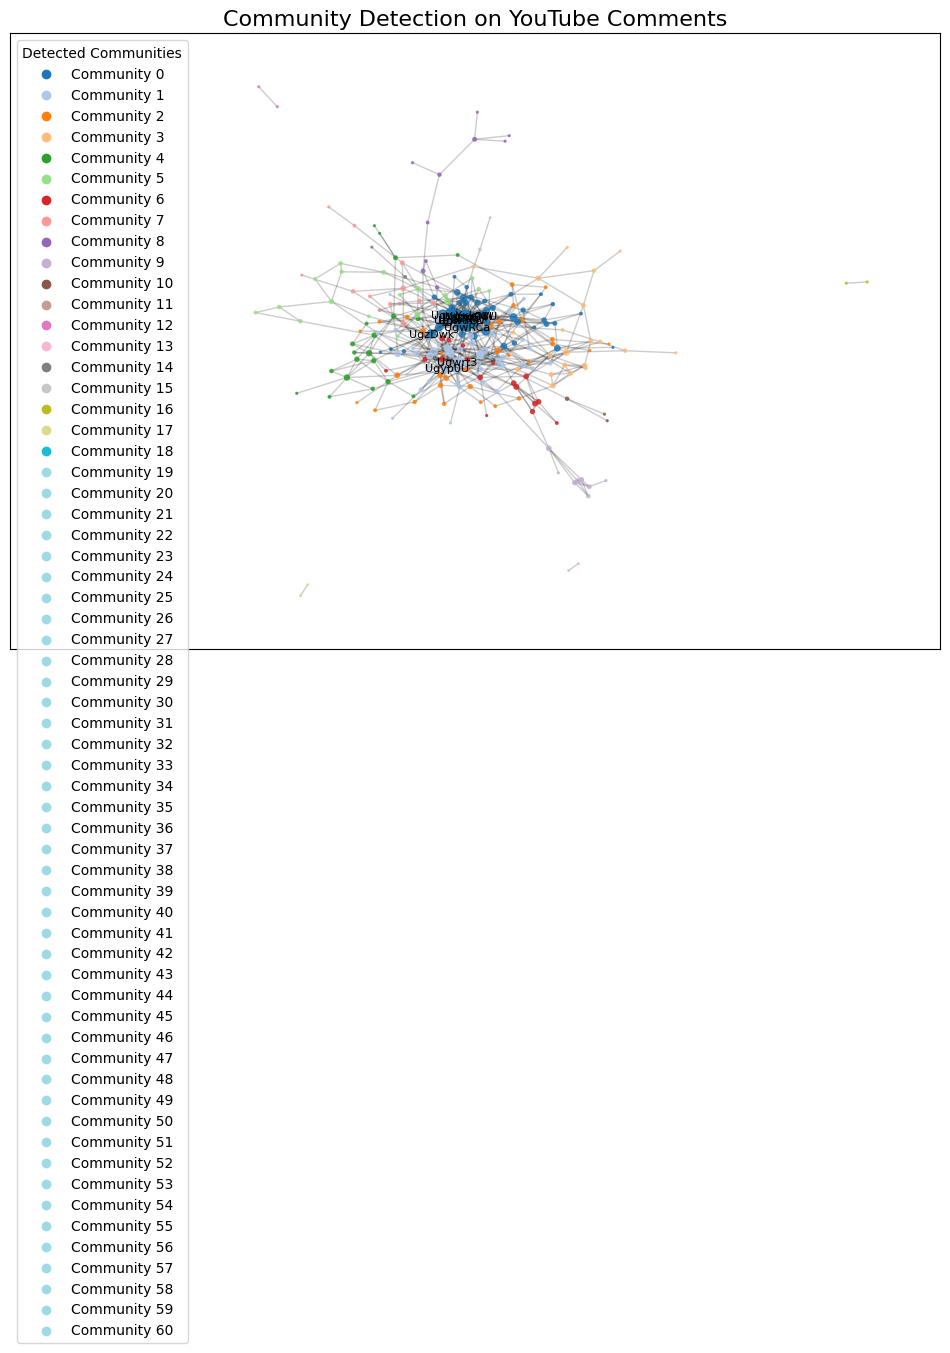

In [ ]:
import sqlite3
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Connect to SQLite database
db_path = "youtube_data.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Load lemmatized comments
query = "SELECT comment_id, lemmatized_text FROM LemmatizedComments WHERE lemmatized_text IS NOT NULL"
comments_df = pd.read_sql_query(query, conn)

# Vectorize the lemmatized text using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(comments_df['lemmatized_text'])

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(tfidf_matrix)

# Create a graph using the similarity matrix
graph = nx.Graph()

# Add nodes (comments)
for i, comment_id in enumerate(comments_df['comment_id']):
    graph.add_node(i, comment_id=comment_id)

# Add edges (only if similarity > threshold)
threshold = 0.2
for i in range(similarity_matrix.shape[0]):
    for j in range(i + 1, similarity_matrix.shape[1]):
        if similarity_matrix[i, j] > threshold:
            graph.add_edge(i, j, weight=similarity_matrix[i, j])

# Apply community detection (Louvain method)
from networkx.algorithms.community import greedy_modularity_communities

communities = list(greedy_modularity_communities(graph))

# Map comments to communities
community_mapping = {}
for community_id, community in enumerate(communities):
    for node in community:
        community_mapping[node] = community_id

# Add community labels to the DataFrame
comments_df['community'] = comments_df.index.map(community_mapping)

### **Save the results into the SQLite database**
cursor.execute("DROP TABLE IF EXISTS CommunityDetection")
cursor.execute("""
    CREATE TABLE CommunityDetection (
        comment_id TEXT PRIMARY KEY,
        community INTEGER,
        FOREIGN KEY (comment_id) REFERENCES Comments (comment_id)
    )
""")

# Insert the processed data
for _, row in comments_df.iterrows():
    cursor.execute("""
        INSERT INTO CommunityDetection (comment_id, community)
        VALUES (?, ?)
    """, (row['comment_id'], row['community']))

# Commit changes and close connection
conn.commit()
conn.close()

print("Community detection results successfully saved to the 'CommunityDetection' table!")

# 🌟 Improved Visualization 🌟
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(graph, seed=42)

# Assign colors to communities
num_communities = len(communities)
colors = [plt.cm.tab20(community_mapping[node] % num_communities) for node in graph.nodes()]

# **Node Size Based on Degree Centrality**
degree_centrality = nx.degree_centrality(graph)
node_sizes = [500 * degree_centrality[node] for node in graph.nodes()]

# **Draw Network Graph**
nx.draw_networkx_nodes(graph, pos, node_color=colors, node_size=node_sizes, alpha=0.8)
nx.draw_networkx_edges(graph, pos, alpha=0.2)

# **Label the Most Central Nodes**
top_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:10]  # Top 10 most connected
labels = {node: comments_df.loc[node, "comment_id"][:6] for node in top_nodes}  # Shortened IDs for readability
nx.draw_networkx_labels(graph, pos, labels, font_size=8, font_color="black")

unique_communities = list(set(community_mapping.values()))
for i, community_id in enumerate(unique_communities):
    plt.scatter([], [], color=plt.cm.tab20(i % num_communities), label=f"Community {community_id}")

plt.legend(title="Detected Communities", loc="best", fontsize=10)
plt.title("Community Detection on YouTube Comments", fontsize=16)
plt.show()


Total Communities Detected: 61


C:\Users\danie\AppData\Local\Temp\ipykernel_21624\2604285772.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = [plt.cm.get_cmap('tab10')(filtered_community_mapping[node] % 10) for node in filtered_graph.nodes()]
C:\Users\danie\AppData\Local\Temp\ipykernel_21624\2604285772.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = [plt.cm.get_cmap('tab10')(filtered_community_mapping[node] % 10) for node in filtered_graph.nodes()]
C:\Users\danie\AppData\Local\Temp\ipykernel_21624\2604285772.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotl

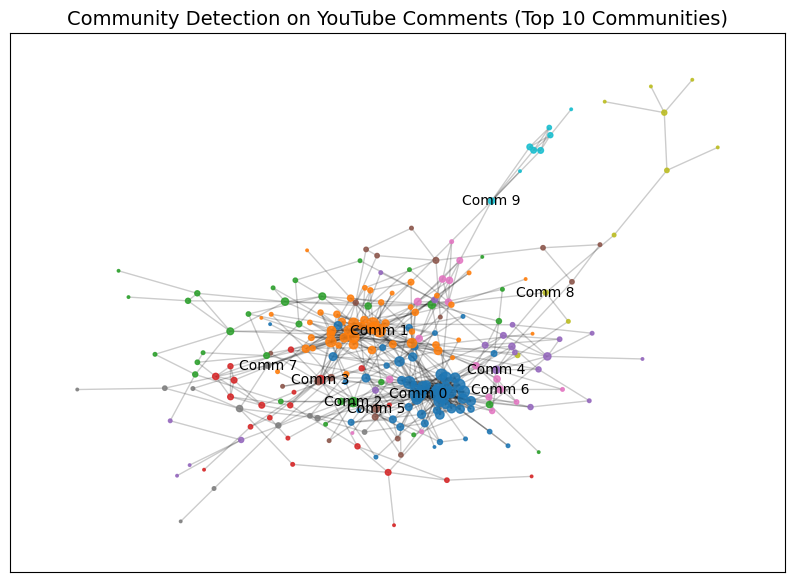

In [63]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Get the number of detected communities
num_communities = len(set(community_mapping.values()))
print(f"Total Communities Detected: {num_communities}")

# Keep only the **top N largest** communities for visualization
top_n = 10
top_communities = sorted(communities, key=len, reverse=True)[:top_n]

# Update community mapping for only the **top N** communities
filtered_nodes = {node for comm in top_communities for node in comm}
filtered_community_mapping = {node: i for i, comm in enumerate(top_communities) for node in comm}

# Filter the graph
filtered_graph = graph.subgraph(filtered_nodes)

# Assign colors to **only the major communities**
colors = [plt.cm.get_cmap('tab10')(filtered_community_mapping[node] % 10) for node in filtered_graph.nodes()]

# Adjust node sizes dynamically based on connectivity (degree centrality)
degree_centrality = nx.degree_centrality(filtered_graph)
node_sizes = [800 * degree_centrality[node] for node in filtered_graph.nodes()]

# **Draw Network Graph**
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(filtered_graph, seed=42)

nx.draw_networkx_nodes(filtered_graph, pos, node_color=colors, node_size=node_sizes, alpha=0.85)
nx.draw_networkx_edges(filtered_graph, pos, alpha=0.2)

# **Label Only Representative Nodes** (1 per community)
for comm_id, comm in enumerate(top_communities):
    rep_node = max(comm, key=lambda n: degree_centrality[n])  # Get most central node per community
    nx.draw_networkx_labels(filtered_graph, pos, labels={rep_node: f"Comm {comm_id}"}, font_size=10, font_color="black")

# Update Title with **Number of Communities**
plt.title(f"Community Detection on YouTube Comments (Top {top_n} Communities)", fontsize=14)
plt.show()


In [64]:
import sqlite3
import pandas as pd
from collections import Counter

# Connect to SQLite database
db_path = "youtube_data.db"
conn = sqlite3.connect(db_path)

# Load community detection results (JOIN CommunityDetection with LemmatizedComments)
query = """
    SELECT cd.comment_id, lc.lemmatized_text, cd.community
    FROM CommunityDetection cd
    JOIN LemmatizedComments lc ON cd.comment_id = lc.comment_id
    WHERE cd.community IS NOT NULL AND lc.lemmatized_text IS NOT NULL
"""
comments_df = pd.read_sql_query(query, conn)

# Close connection
conn.close()

# Extract top words per community
def get_top_words(text_series, top_n=10):
    all_words = " ".join(text_series).split()
    most_common = Counter(all_words).most_common(top_n)
    return ", ".join([word for word, _ in most_common])

# Get top words for each community
community_keywords = comments_df.groupby("community")["lemmatized_text"].apply(lambda x: get_top_words(x, top_n=10)).reset_index()
community_keywords.columns = ["Community", "Top Words"]

# Save to SQLite
conn = sqlite3.connect(db_path)
cursor = conn.cursor()
cursor.execute("DROP TABLE IF EXISTS CommunityKeywords")
cursor.execute("""
    CREATE TABLE CommunityKeywords (
        community INTEGER PRIMARY KEY,
        top_words TEXT
    )
""")

# Insert the extracted keywords
for _, row in community_keywords.iterrows():
    cursor.execute("INSERT INTO CommunityKeywords (community, top_words) VALUES (?, ?)", (row["Community"], row["Top Words"]))

conn.commit()
conn.close()

print("Community keyword extraction completed and saved to SQLite!")


Community keyword extraction completed and saved to SQLite!


In [ ]:
# Get the top 10 largest communities
top_10_communities = comments_df["community"].value_counts().index[:10]

# Extract top words with frequency for each of the top 5 communities
def get_top_words_with_counts(text_series, top_n=10):
    all_words = " ".join(text_series).split()
    most_common = Counter(all_words).most_common(top_n)
    return most_common  # Returns list of tuples (word, count)

# get the top 5 words of each community
community_word_counts = comments_df[comments_df["community"].isin(top_10_communities)] \
    .groupby("community")["lemmatized_text"] \
    .apply(lambda x: get_top_words_with_counts(x, top_n=5)) \
    .reset_index()

community_word_counts.columns = ["Community", "Top Words"]

# Plot bar charts for each of the top 5 communities
for _, row in community_word_counts.iterrows():
    community_id = row["Community"]
    words, counts = zip(*row["Top Words"])  # Unpack words and counts

    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(counts), y=list(words), palette="viridis")
    plt.xlabel("Word Frequency")
    plt.ylabel("Top Words")
    plt.title(f"Top Words in Community {community_id}")
    plt.show()


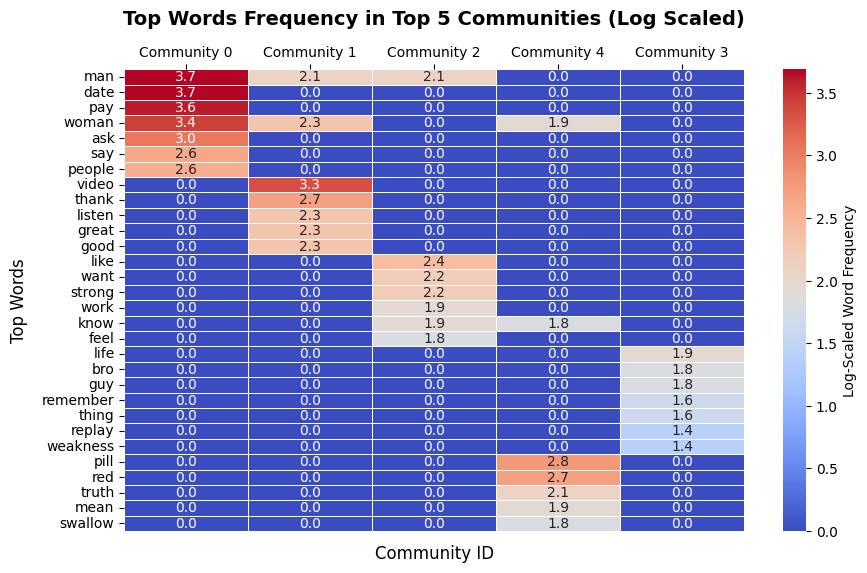

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

# Get the top 5 largest communities
top_5_communities = comments_df["community"].value_counts().index[:5]

# Extract top words with frequency for each of the top 5 communities
def get_top_words_with_counts(text_series, top_n=7):
    all_words = " ".join(text_series.dropna()).split()
    most_common = Counter(all_words).most_common(top_n)
    return {word: count for word, count in most_common}  # Returns dictionary of words and counts

# Creating a structured DataFrame for heatmap visualization
heatmap_data_dict = {}

for community in top_5_communities:
    top_words_counts = get_top_words_with_counts(
        comments_df[comments_df["community"] == community]["lemmatized_text"],
        top_n=7
    )
    heatmap_data_dict[f"Community {community}"] = top_words_counts

# Convert to DataFrame, filling missing values with 0
heatmap_data = pd.DataFrame.from_dict(heatmap_data_dict, orient='index').fillna(0)

# Apply log transformation for better visibility
heatmap_data = np.log1p(heatmap_data)  # log1p avoids log(0) issues

# ----------------------------
# **Improved Heatmap Plot**
# ----------------------------
plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    heatmap_data.T, 
    cmap="coolwarm",  
    annot=True, 
    fmt=".1f",  # Round annotations to 1 decimal place
    linewidths=0.6, 
    cbar_kws={'label': 'Log-Scaled Word Frequency'}
)
plt.title("Top Words Frequency in Top 5 Communities (Log Scaled)", fontsize=14, fontweight='bold', pad=15)
plt.xlabel("Community ID", fontsize=12, labelpad=10)
plt.ylabel("Top Words", fontsize=12, labelpad=10)
plt.xticks(rotation=30, fontsize=10, ha="right")  # Rotate x-axis labels for clarity
plt.yticks(fontsize=10, rotation=0)  # Keep y-axis labels horizontal
ax.xaxis.tick_top()  # Move x-axis labels to the top for better readability

plt.show()


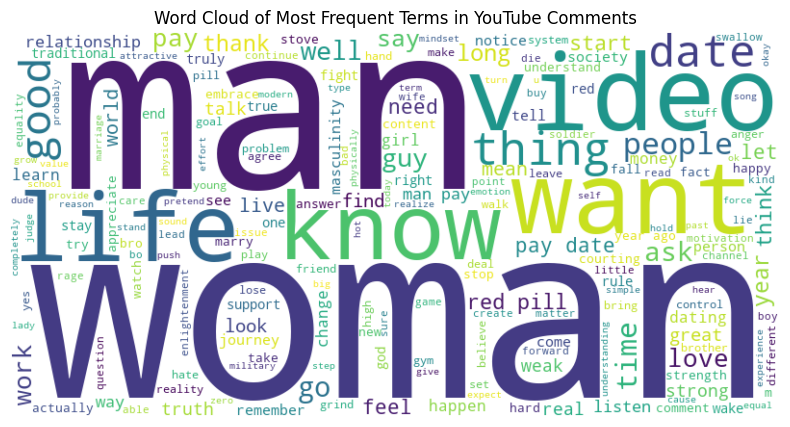

In [ ]:


from wordcloud import WordCloud


# Connect to the SQLite database
db_path = "youtube_data.db"
conn = sqlite3.connect(db_path)

# Load the lemmatized comments data
query = "SELECT lemmatized_text FROM LemmatizedComments"
df = pd.read_sql_query(query, conn)
conn.close()

# Combine all comments into one large text corpus
text_corpus = " ".join(df['lemmatized_text'].dropna())

# Generate the word cloud
wordcloud = WordCloud(
    width=800, height=400, background_color="white", max_words=200, colormap="viridis"
).generate(text_corpus)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Most Frequent Terms in YouTube Comments")
plt.show()



# Topic modelling

In [16]:
!pip uninstall -y numpy scipy gensim
!pip install --no-cache-dir numpy scipy gensim


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: scipy 1.13.1
Uninstalling scipy-1.13.1:
  Successfully uninstalled scipy-1.13.1
Found existing installation: gensim 4.3.3
Uninstalling gensim-4.3.3:
  Successfully uninstalled gensim-4.3.3


You can safely remove it manually.
You can safely remove it manually.


     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.8 kB ? eta -:--:--
     ------------ ------------------------- 20.5/60.8 kB 165.2 kB/s eta 0:00:01
     ------------------------- ------------ 41.0/60.8 kB 245.8 kB/s eta 0:00:01
     -------------------------------------- 60.8/60.8 kB 324.4 kB/s eta 0:00:00
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ---------------------------------------- 60.8/60.8 kB 1.6 MB/s eta 0:00:00
     ---------------------------------------- 0.0/61.0 kB ? eta -:--:--
     ---------------------------------------- 61.0/61.0 kB ? eta 0:00:00
     ---------------------------------------- 0.0/60.6 kB ? eta -:--:--
     ---------------------------------------- 60.6/60.6 kB ? eta 0:00:00
   ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
    --------------------------------------- 0.4/24.0 MB 8.1 MB/s eta 0:00:03
   - ---------------------


[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


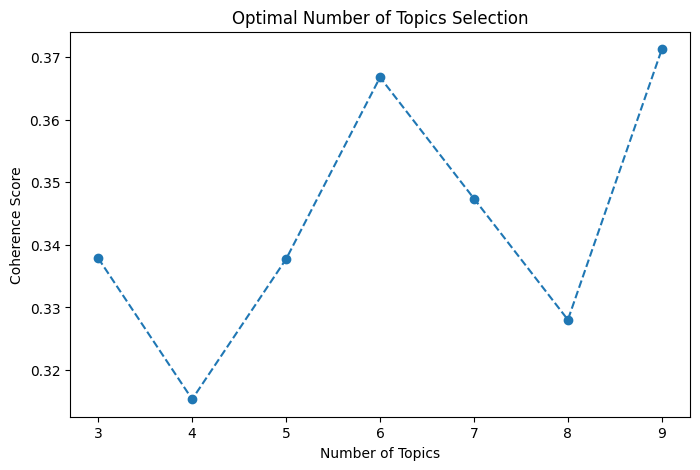

Topic 1: 0.129*"life" + 0.055*"live" + 0.049*"thing" + 0.045*"truth" + 0.035*"red_pill" + 0.034*"start" + 0.031*"know" + 0.030*"change" + 0.029*"work" + 0.028*"like"
Topic 2: 0.076*"well" + 0.058*"man" + 0.043*"video" + 0.037*"people" + 0.036*"woman" + 0.035*"good" + 0.030*"go" + 0.028*"think" + 0.026*"want" + 0.026*"traditional"
Topic 3: 0.100*"video" + 0.064*"thank" + 0.055*"man" + 0.053*"lose" + 0.048*"woman" + 0.042*"talk" + 0.039*"need" + 0.038*"long" + 0.037*"listen" + 0.035*"stop"
Topic 4: 0.064*"let" + 0.061*"people" + 0.055*"tell" + 0.052*"happen" + 0.046*"society" + 0.046*"long" + 0.036*"talk" + 0.031*"time" + 0.030*"young" + 0.023*"life"
Topic 5: 0.074*"know" + 0.052*"woman" + 0.046*"guy" + 0.045*"look" + 0.036*"man" + 0.034*"good" + 0.030*"world" + 0.030*"red_pill" + 0.027*"money" + 0.023*"like"
Topic 6: 0.067*"woman" + 0.054*"thing" + 0.047*"notice" + 0.046*"bring" + 0.037*"fall" + 0.030*"actually" + 0.028*"take" + 0.028*"understand" + 0.028*"long" + 0.027*"change"
Topic 7

In [ ]:
# Install necessary libraries
#!pip install pyLDAvis 

import sqlite3
import pandas as pd
import gensim
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import nltk
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt

# Ensure necessary resources are downloaded
nltk.download('stopwords')

db_path = "youtube_data.db"
conn = sqlite3.connect(db_path)


query = "SELECT lemmatized_text FROM LemmatizedComments WHERE lemmatized_text IS NOT NULL"
df = pd.read_sql_query(query, conn)
conn.close()


stop_words = set(stopwords.words('english'))
df["tokens"] = df["lemmatized_text"].apply(lambda x: [word for word in x.split() if word not in stop_words])

# Filter out empty and very short comments (less than 3 words)
df = df[df["tokens"].str.len() > 2]

# Create bigrams to capture phrases 
bigram = gensim.models.Phrases(df["tokens"], min_count=5, threshold=10)
bigram_mod = gensim.models.Phrases(bigram[df["tokens"]])

df["tokens"] = df["tokens"].apply(lambda x: bigram_mod[x])

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(df["tokens"])
dictionary.filter_extremes(no_below=5, no_above=0.5)  # Remove very rare and overly common words
corpus = [dictionary.doc2bow(text) for text in df["tokens"]]

# Determine the Optimal Number of Topics using Coherence Score
def compute_coherence(dictionary, corpus, texts, start=3, limit=10, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10, random_state=42)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    
    return model_list, coherence_values

# Compute coherence scores for topic range
model_list, coherence_values = compute_coherence(dictionary, corpus, df["tokens"], start=3, limit=10, step=1)

# Plot coherence scores to visualize optimal topic number
plt.figure(figsize=(8, 5))
plt.plot(range(3, 10), coherence_values, marker="o", linestyle="dashed")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Optimal Number of Topics Selection")
plt.show()

# Select the best model (highest coherence score)
optimal_num_topics = range(3, 10)[coherence_values.index(max(coherence_values))]
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=optimal_num_topics, passes=10, random_state=42)

# Display Topics
for idx, topic in lda_model.print_topics(num_words=10):
    print(f"Topic {idx+1}: {topic}")

# Prepare Visualization
lda_display = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)

# Show interactive visualization
pyLDAvis.display(lda_display)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


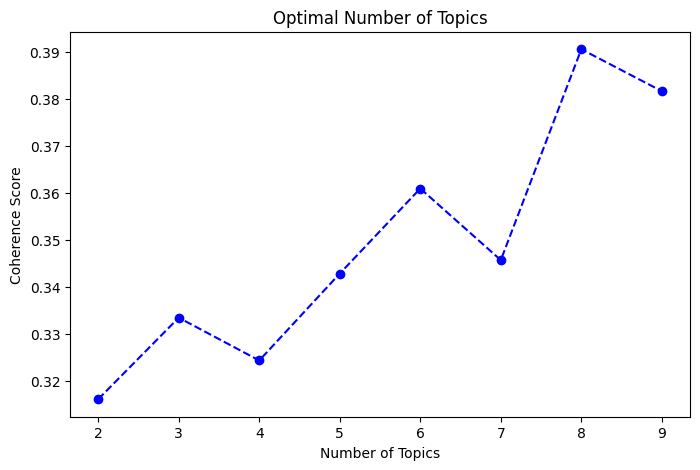

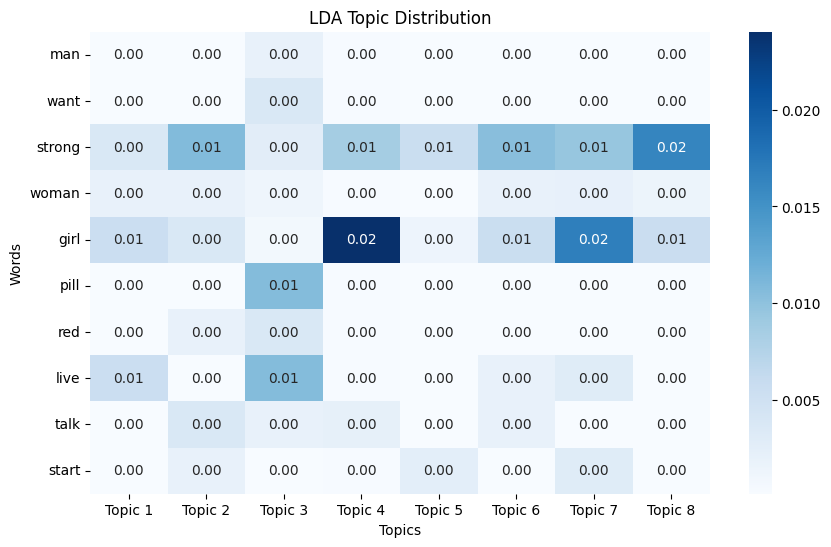

In [ ]:
# Install necessary libraries if not already installed
#!pip install gensim nltk matplotlib seaborn

import sqlite3
import pandas as pd
import gensim
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Download stopwords if not already present
nltk.download('stopwords')

# Connect to SQLite database
db_path = "youtube_data.db"
conn = sqlite3.connect(db_path)

# Load the lemmatized comments
query = "SELECT lemmatized_text FROM LemmatizedComments WHERE lemmatized_text IS NOT NULL"
df = pd.read_sql_query(query, conn)
conn.close()

# Tokenization and Stopword Removal
stop_words = set(stopwords.words('english'))
df["tokens"] = df["lemmatized_text"].apply(lambda x: [word for word in x.split() if word not in stop_words and len(word) > 2])

# Create Dictionary and Corpus
dictionary = corpora.Dictionary(df["tokens"])
corpus = [dictionary.doc2bow(text) for text in df["tokens"]]

# Determine Optimal Number of Topics
coherence_scores = []
topic_range = range(2, 10)  # Testing topic numbers from 2 to 10

for num_topics in topic_range:
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10, random_state=42)
    coherence_model = CoherenceModel(model=lda_model, texts=df["tokens"], dictionary=dictionary, coherence='c_v')
    coherence_scores.append(coherence_model.get_coherence())

# Plot Coherence Scores
plt.figure(figsize=(8, 5))
plt.plot(topic_range, coherence_scores, marker='o', linestyle='--', color='b')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Optimal Number of Topics")
plt.show()

# Train LDA with Optimal Topic Count
optimal_topics = topic_range[coherence_scores.index(max(coherence_scores))]
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=optimal_topics, passes=10, random_state=42)

# Extract and Display Topics
topic_words = {f"Topic {idx+1}": [word for word, _ in lda_model.show_topic(idx, topn=10)] for idx in range(optimal_topics)}
topic_df = pd.DataFrame(topic_words)

# Display heatmap for topics
plt.figure(figsize=(10, 6))
sns.heatmap(pd.DataFrame(lda_model.get_topics()).T[:10], cmap="Blues", annot=True, fmt=".2f", xticklabels=topic_words.keys(), yticklabels=topic_df.iloc[:, 0])
plt.title("LDA Topic Distribution")
plt.xlabel("Topics")
plt.ylabel("Words")
plt.show()


In [62]:
import sqlite3
import pandas as pd
import gensim
from gensim import corpora
from gensim.models import LdaModel
import numpy as np
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# Connect to SQLite database
db_path = "youtube_data.db"
conn = sqlite3.connect(db_path)

# Load the lemmatized comments
query = "SELECT comment_id, lemmatized_text FROM LemmatizedComments WHERE lemmatized_text IS NOT NULL"
df = pd.read_sql_query(query, conn)

# Tokenize comments
stop_words = set(stopwords.words('english'))
df["tokens"] = df["lemmatized_text"].apply(lambda x: [word for word in x.split() if word not in stop_words])

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(df["tokens"])
corpus = [dictionary.doc2bow(text) for text in df["tokens"]]

# Number of topics (based on coherence score optimization)
num_topics = 8

# Train LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10, random_state=42)

# Assign each comment to the most probable topic
def get_dominant_topic(lda_model, bow):
    topic_probs = lda_model.get_document_topics(bow, minimum_probability=0)
    return max(topic_probs, key=lambda x: x[1])[0]  # Get the topic with the highest probability

df["assigned_topic"] = df["tokens"].apply(lambda x: get_dominant_topic(lda_model, dictionary.doc2bow(x)))

# Store topic assignments in the database
cursor = conn.cursor()

# Create the TopicModeling table
cursor.execute("""
    CREATE TABLE IF NOT EXISTS TopicModeling (
        comment_id TEXT PRIMARY KEY,
        topic INTEGER,
        FOREIGN KEY (comment_id) REFERENCES LemmatizedComments(comment_id)
    )
""")

# Insert topic assignments into the database
topic_results = [(row["comment_id"], row["assigned_topic"]) for _, row in df.iterrows()]
cursor.executemany("INSERT INTO TopicModeling (comment_id, topic) VALUES (?, ?)", topic_results)

# Commit changes and close connection
conn.commit()
conn.close()

print("Topics successfully assigned to comments and saved in the database!")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Topics successfully assigned to comments and saved in the database!


# Sentient Analysis

In [65]:
import sqlite3
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('vader_lexicon')

# Connect to SQLite database
db_path = "youtube_data.db"
conn = sqlite3.connect(db_path)

# Retrieve topic-assigned comments
query = """
    SELECT lc.lemmatized_text, tm.topic
    FROM TopicModeling tm
    JOIN LemmatizedComments lc ON tm.comment_id = lc.comment_id
    WHERE tm.topic IS NOT NULL AND lc.lemmatized_text IS NOT NULL
"""
df = pd.read_sql_query(query, conn)
conn.close()

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to compute sentiment score
def get_sentiment_score(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']  # Compound score (-1 to 1, where >0 = positive, <0 = negative)

# Apply sentiment analysis to each comment
df["sentiment_score"] = df["lemmatized_text"].apply(get_sentiment_score)

# Categorize into sentiment groups
df["sentiment_category"] = pd.cut(df["sentiment_score"], bins=[-1, -0.05, 0.05, 1], labels=["Negative", "Neutral", "Positive"])

# Aggregate sentiment counts per topic
topic_sentiment = df.groupby(["topic", "sentiment_category"]).size().unstack().fillna(0)

# Normalize sentiment distribution
topic_sentiment_normalized = topic_sentiment.div(topic_sentiment.sum(axis=1), axis=0)




[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
C:\Users\danie\AppData\Local\Temp\ipykernel_36852\1193769787.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  topic_sentiment = df.groupby(["topic", "sentiment_category"]).size().unstack().fillna(0)


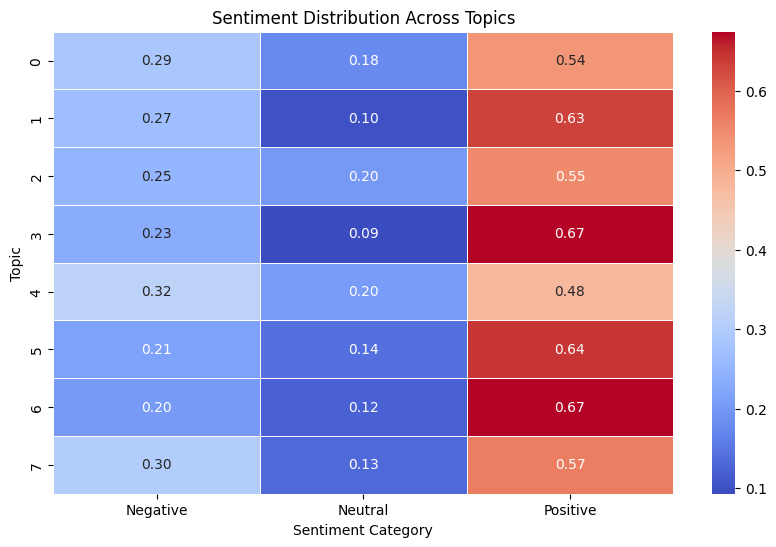

In [66]:
# Plot sentiment heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(topic_sentiment_normalized, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.xlabel("Sentiment Category")
plt.ylabel("Topic")
plt.title("Sentiment Distribution Across Topics")
plt.show()


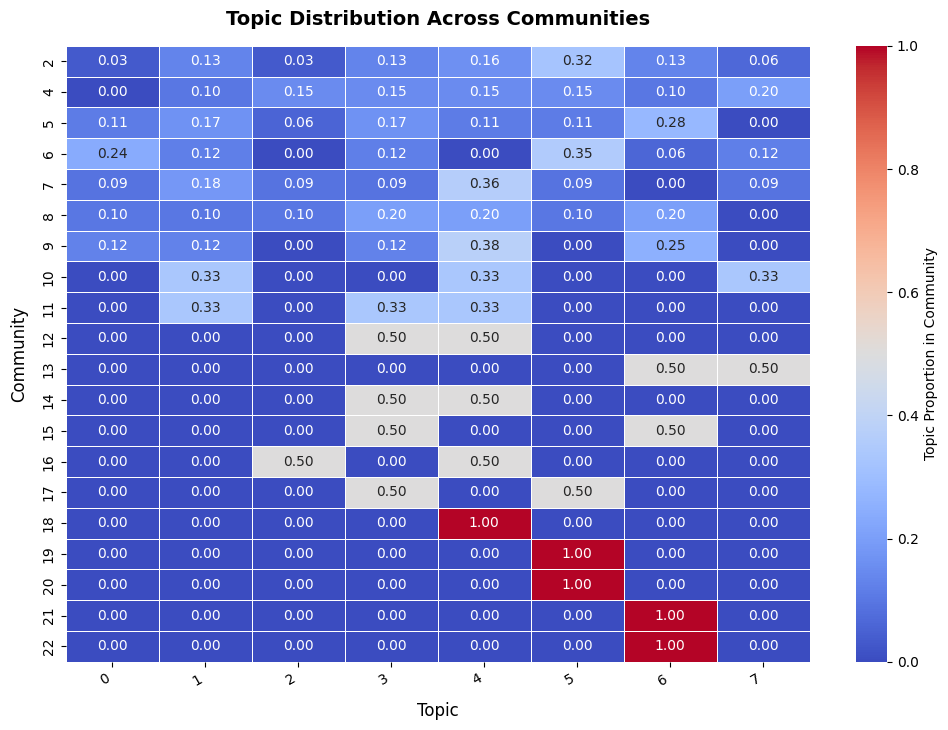

In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to SQLite database
db_path = "youtube_data.db"
conn = sqlite3.connect(db_path)

# Load topic-community mapping
query = """
    SELECT tm.comment_id, tm.topic, cd.community, lc.video_id
    FROM TopicModeling tm
    JOIN CommunityDetection cd ON tm.comment_id = cd.comment_id
    JOIN LemmatizedComments lc ON tm.comment_id = lc.comment_id
    WHERE tm.topic IS NOT NULL AND cd.community IS NOT NULL AND lc.video_id IS NOT NULL
"""
topic_community_video_df = pd.read_sql_query(query, conn)

# Close connection
conn.close()

# ----------------------------
# Topic Distribution by Community (Improved Aesthetics)
# ----------------------------
topic_community_distribution = topic_community_video_df.groupby(["community", "topic"]).size().unstack(fill_value=0)

# Normalize by community (percentage of each topic in a community)
topic_community_distribution = topic_community_distribution.div(topic_community_distribution.sum(axis=1), axis=0)

# Sort by most active communities (optional)
top_20_communities = topic_community_distribution.sum(axis=1).nlargest(20).index
topic_community_distribution = topic_community_distribution.loc[top_20_communities]

# Plot improved heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    topic_community_distribution, 
    cmap="coolwarm", 
    annot=True,  # Avoid cluttering the plot
    fmt=".2f", 
    linewidths=0.5,
    cbar_kws={'label': 'Topic Proportion in Community'}
)

# Improve aesthetics
plt.title("Topic Distribution Across Communities", fontsize=14, fontweight='bold', pad=15)
plt.xlabel("Topic", fontsize=12, labelpad=10)
plt.ylabel("Community", fontsize=12, labelpad=10)
plt.xticks(rotation=30, fontsize=10, ha="right")
plt.yticks(fontsize=10)
plt.show()


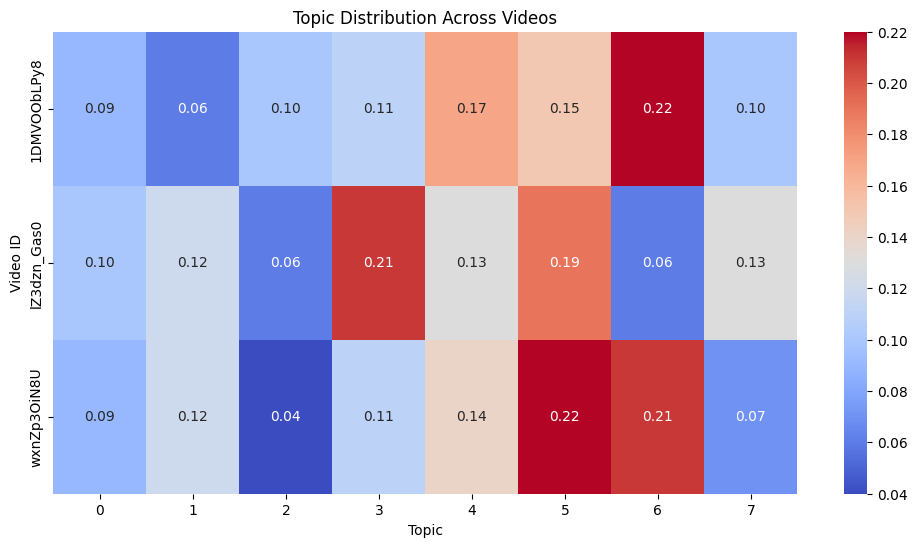

In [41]:
# ----------------------------
# Topic Distribution by Video
# ----------------------------
topic_video_distribution = topic_community_video_df.groupby(["video_id", "topic"]).size().unstack(fill_value=0)

# Normalize by video (percentage of each topic in a video)
topic_video_distribution = topic_video_distribution.div(topic_video_distribution.sum(axis=1), axis=0)

# Plot heatmap for topic-video mapping
plt.figure(figsize=(12, 6))
sns.heatmap(topic_video_distribution, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Topic Distribution Across Videos")
plt.xlabel("Topic")
plt.ylabel("Video ID")
plt.show()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


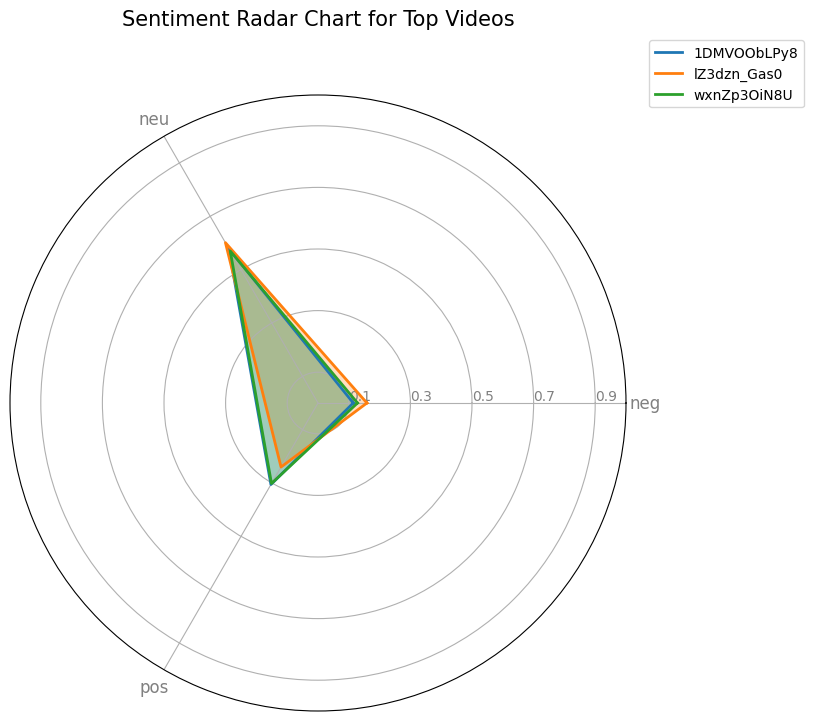

In [ ]:
import sqlite3
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import numpy as np

# Download required VADER lexicon
nltk.download('vader_lexicon')

# load comments with their video IDs
db_path = "youtube_data.db"
conn = sqlite3.connect(db_path)
query = """
    SELECT comment_id, lemmatized_text, video_id 
    FROM LemmatizedComments 
    WHERE lemmatized_text IS NOT NULL AND video_id IS NOT NULL
"""
df = pd.read_sql_query(query, conn)
conn.close()

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Compute sentiment scores for each comment
df['neg'] = df['lemmatized_text'].apply(lambda x: sia.polarity_scores(x)['neg'])
df['neu'] = df['lemmatized_text'].apply(lambda x: sia.polarity_scores(x)['neu'])
df['pos'] = df['lemmatized_text'].apply(lambda x: sia.polarity_scores(x)['pos'])
df['compound'] = df['lemmatized_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Group by video_id to compute the average sentiment scores per video
video_sentiments = df.groupby('video_id')[['neg', 'neu', 'pos', 'compound']].mean().reset_index()

# (Optional) If you have many videos, pick the top N with the most comments
video_counts = df['video_id'].value_counts().reset_index()
video_counts.columns = ['video_id', 'count']
top_videos = video_counts.head(5)['video_id'].tolist()  # adjust N as needed
video_sentiments_top = video_sentiments[video_sentiments['video_id'].isin(top_videos)]

# radar plot
def plot_radar_chart(data, categories, title):
    N = len(categories)
    # Compute angle for each axis and complete the loop
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    # Initialize the radar chart
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Draw one axis per variable with labels
    plt.xticks(angles[:-1], categories, color='grey', size=12)

    # Set y-labels and range (since scores are between 0 and 1)
    ax.set_rlabel_position(0)
    plt.yticks([0.1, 0.3, 0.5, 0.7, 0.9], ["0.1", "0.3", "0.5", "0.7", "0.9"], color="grey", size=10)
    plt.ylim(0, 1)

    # Plot data for each video
    for idx, row in data.iterrows():
        # Extract the sentiment values and complete the loop for the radar chart
        values = row[categories].tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=row['video_id'])
        ax.fill(angles, values, alpha=0.25)

    plt.title(title, size=15, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

sentiment_categories = ['neg', 'neu', 'pos']

# Plot the radar chart for the top videos
plot_radar_chart(video_sentiments_top, sentiment_categories, "Sentiment Radar Chart for Top Videos")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


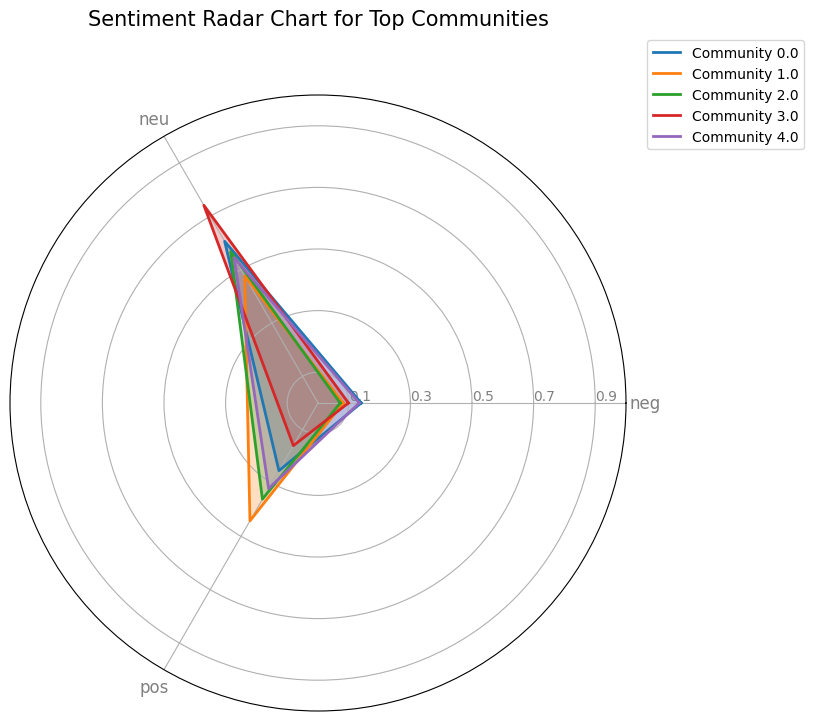

In [60]:
import sqlite3
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import numpy as np

nltk.download('vader_lexicon')

# Connect to SQLite database and load comments with their community labels
db_path = "youtube_data.db"
conn = sqlite3.connect(db_path)
query = """
    SELECT lc.comment_id, lc.lemmatized_text, cd.community
    FROM LemmatizedComments lc
    JOIN CommunityDetection cd ON lc.comment_id = cd.comment_id
    WHERE lc.lemmatized_text IS NOT NULL AND cd.community IS NOT NULL
"""
df = pd.read_sql_query(query, conn)
conn.close()

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Compute sentiment scores for each comment
df['neg'] = df['lemmatized_text'].apply(lambda x: sia.polarity_scores(x)['neg'])
df['neu'] = df['lemmatized_text'].apply(lambda x: sia.polarity_scores(x)['neu'])
df['pos'] = df['lemmatized_text'].apply(lambda x: sia.polarity_scores(x)['pos'])
df['compound'] = df['lemmatized_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Group by community to compute the average sentiment scores per community
community_sentiments = df.groupby('community')[['neg', 'neu', 'pos', 'compound']].mean().reset_index()


community_counts = df['community'].value_counts().reset_index()
community_counts.columns = ['community', 'count']
top_communities = community_counts.head(5)['community'].tolist()
community_sentiments_top = community_sentiments[community_sentiments['community'].isin(top_communities)]


def plot_radar_chart(data, categories, title):
    N = len(categories)
    # Compute angle for each axis and complete the loop
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    # Initialize the radar chart
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Draw one axis per variable with labels
    plt.xticks(angles[:-1], categories, color='grey', size=12)

    # Set y-labels and range (since sentiment scores are between 0 and 1)
    ax.set_rlabel_position(0)
    plt.yticks([0.1, 0.3, 0.5, 0.7, 0.9], ["0.1", "0.3", "0.5", "0.7", "0.9"], color="grey", size=10)
    plt.ylim(0, 1)

    # Plot data for each community
    for idx, row in data.iterrows():
        values = row[categories].tolist()
        values += values[:1]  # Complete the loop for radar chart
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Community {row["community"]}')
        ax.fill(angles, values, alpha=0.25)

    plt.title(title, size=15, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

# Define the sentiment metrics you want to plot (e.g., negative, neutral, and positive)
sentiment_categories = ['neg', 'neu', 'pos']

# Plot the radar chart for the top communities
plot_radar_chart(community_sentiments_top, sentiment_categories, "Sentiment Radar Chart for Top Communities")
